<a href="https://colab.research.google.com/github/ClovisMonteiro/Analise_notas_de_filmes_TMDB/blob/master/Tcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando Bibliotecas

In [22]:
pip install -U scikit-image

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout , BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau



### Análise da base de imagens

In [24]:
train_data = glob.glob('drive/MyDrive/PROJETO TCC 2/Imagens_database/train/**/*.jpeg')
test_data = glob.glob('drive/MyDrive/PROJETO TCC 2/Imagens_database/test/**/*.jpeg')
val_data = glob.glob('drive/MyDrive/PROJETO TCC 2/Imagens_database/val/**/*.jpeg')


print(f"Training Set tem: {len(train_data)} images")
print(f"Testing Set tem: {len(test_data)} images")
print(f"Validation Set tem: {len(val_data)} images")


Training Set tem: 28622 images
Testing Set tem: 5277 images
Validation Set tem: 7077 images


In [26]:
os.listdir('drive/MyDrive/PROJETO TCC 2/Imagens_database/test')

['opacity', 'normal']

In [27]:
DIR = "drive/MyDrive/PROJETO TCC 2/Imagens_database"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "normal/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "opacity/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 29897
Total Normal Images: 11079


### Visualizações

In [28]:
labels = ["Normal",'Covid-19 ']
values = [len(all_normal), len(all_pneumonia)]
colors = ['blue', 'red']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Distribuição da categoria das imagens",
                  titlefont={'size': 10},      
                  )
iplot(fig)


In [29]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

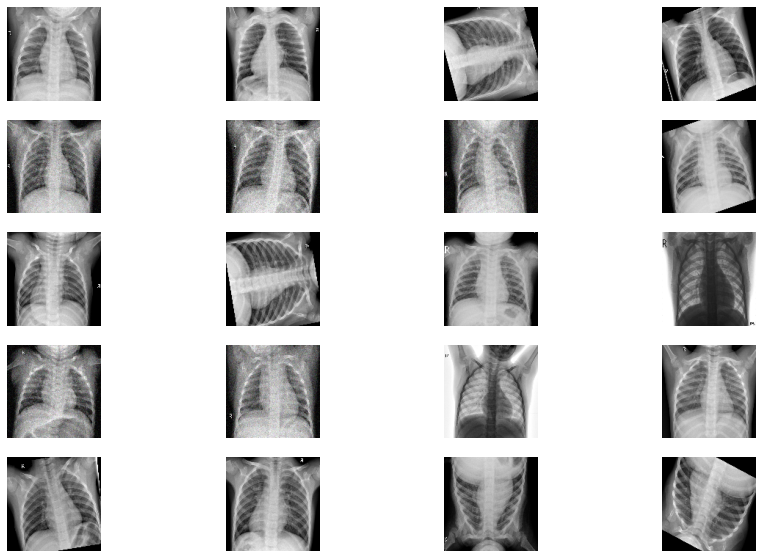

In [30]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

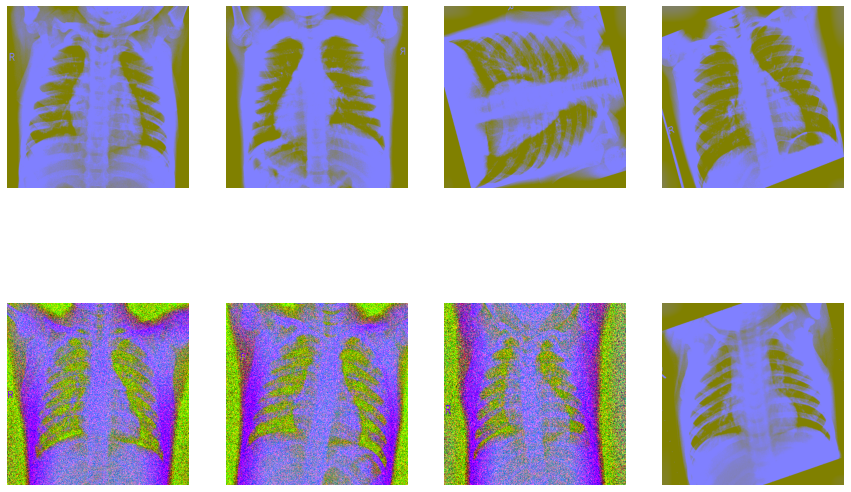

In [31]:
# O desfoque gaussiano é o resultado do desfoque de uma imagem por uma função gaussiana

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

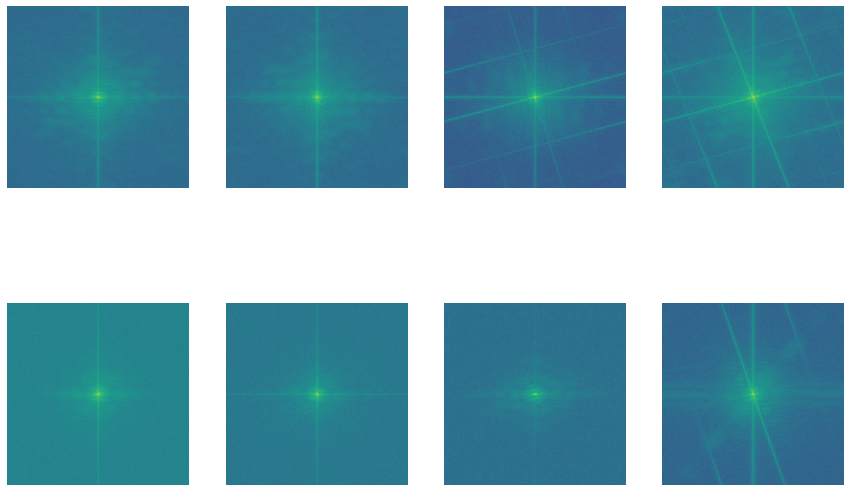

In [32]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

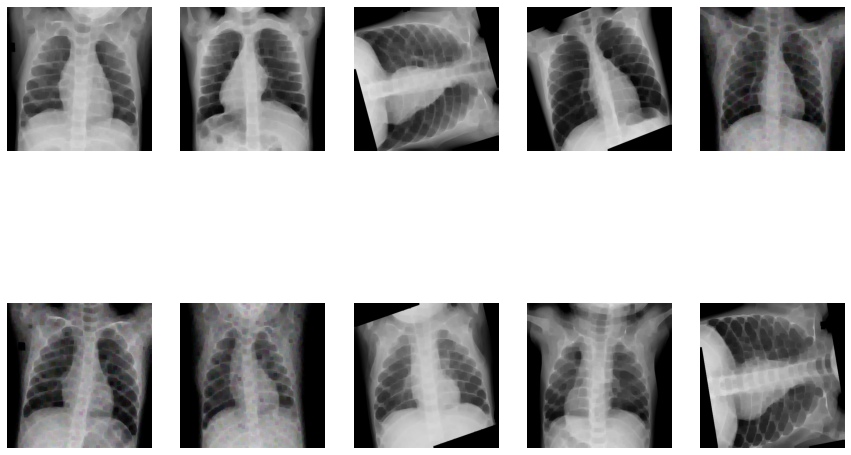

In [33]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

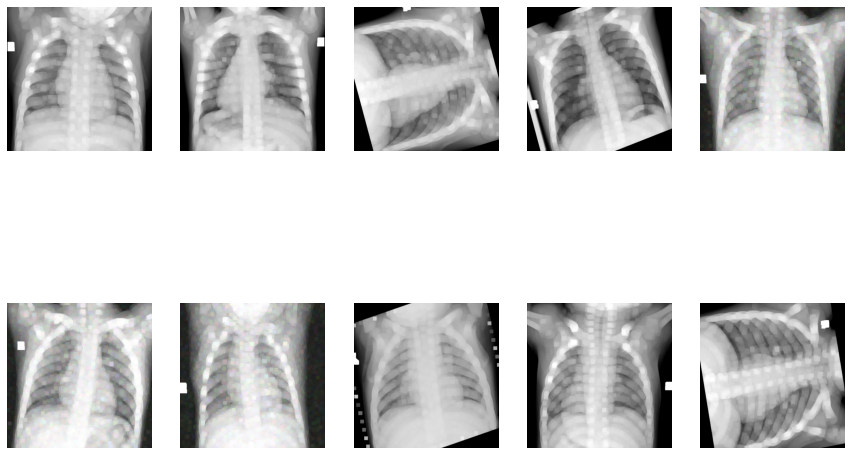

In [34]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

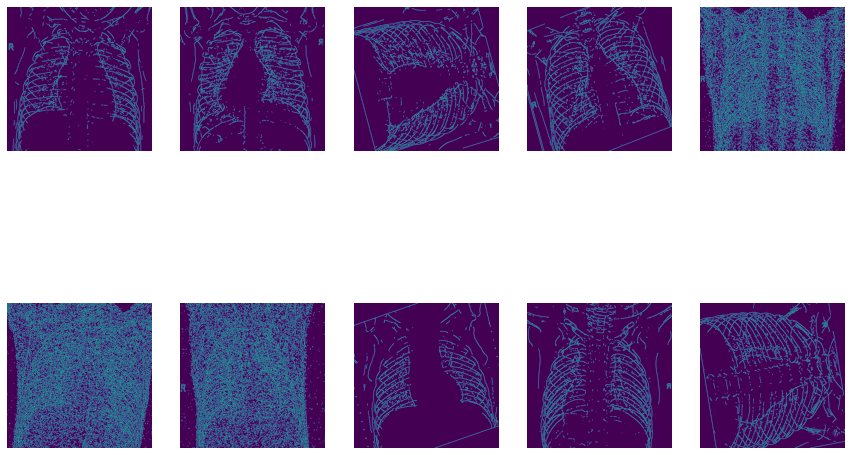

In [35]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

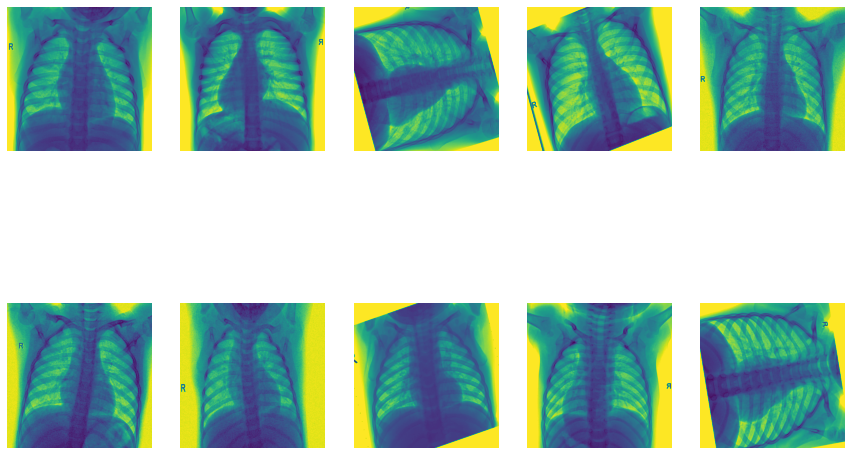

In [36]:
# IMPLEMENTANDO A INVERSÃO das imagens 
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    Invert = 256 - np.array(img)

    fig.add_subplot(rows, columns, i)
    plt.imshow(Invert)
    plt.axis(False)

### Iniciando processamento

In [37]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    #horizontal_flip=True,
    #vertical_flip=False,
    #rotation_range=0.3,
    #zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [38]:
train_gen

In [39]:
Train = train_gen.flow_from_directory(
    "drive/MyDrive/PROJETO TCC 2/Imagens_database/train/",batch_size=16,
    target_size=(224, 224),#class_mode="binary" 
)
val = train_gen.flow_from_directory(
    "drive/MyDrive/PROJETO TCC 2/Imagens_database/test",batch_size=8,
    target_size=(224, 224),#class_mode="binary" 
)

Found 28622 images belonging to 2 classes.
Found 5277 images belonging to 2 classes.


In [40]:
model = Sequential()
model.add(Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 128)     

In [41]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

history = model.fit(Train, epochs=10, validation_data = val, steps_per_epoch=50, callbacks=[early_stopping_cb])

Epoch 1/10
50/50 [==============================] - 575s 12s/step - loss: 0.5932 - accuracy: 0.7212 - val_loss: 0.4904 - val_accuracy: 0.8253
Epoch 2/10
50/50 [==============================] - 484s 10s/step - loss: 0.4879 - accuracy: 0.7475 - val_loss: 0.3854 - val_accuracy: 0.8086
Epoch 3/10
50/50 [==============================] - 468s 9s/step - loss: 0.4218 - accuracy: 0.8000 - val_loss: 0.3086 - val_accuracy: 0.8757
Epoch 4/10
50/50 [==============================] - 466s 9s/step - loss: 0.4048 - accuracy: 0.8188 - val_loss: 0.3350 - val_accuracy: 0.8658
Epoch 5/10
50/50 [==============================] - 452s 9s/step - loss: 0.3778 - accuracy: 0.8250 - val_loss: 0.2604 - val_accuracy: 0.9024
Epoch 6/10
50/50 [==============================] - 455s 9s/step - loss: 0.2911 - accuracy: 0.8788 - val_loss: 0.2616 - val_accuracy: 0.8965
Epoch 7/10
50/50 [==============================] - 456s 9s/step - loss: 0.3286 - accuracy: 0.8450 - val_loss: 0.2655 - val_accuracy: 0.8952
Epoch 8/10


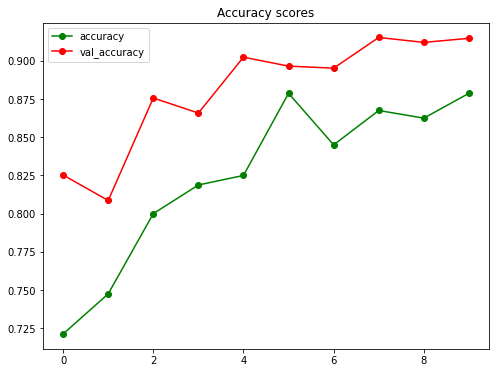

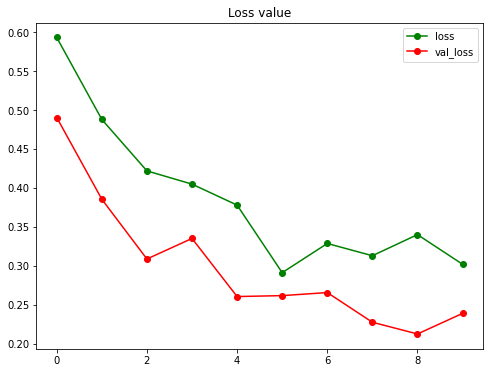

In [43]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(history.history['accuracy'],'go-')
plt.plot(history.history['val_accuracy'],'ro-')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(history.history['loss'],'go-')
plt.plot(history.history['val_loss'],'ro-')
plt.legend(['loss', 'val_loss'])
plt.show()

# Cenceito de transfer Learning

In [44]:
base_model = VGG16(include_top=False, weights=None, input_shape=(224,224,3), pooling='avg', classes=2)

In [45]:
base_model.load_weights("/content/drive/MyDrive/PROJETO TCC 2/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [46]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [47]:
model=Sequential()
model.add(base_model)
model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))

## Freezing the layers
for layer in base_model.layers:
    layer.trainable=False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(Train,epochs=20,validation_data=val,steps_per_epoch=50,callbacks=[early_stopping_cb])

Epoch 1/20
50/50 [==============================] - 3105s 63s/step - loss: 0.5907 - accuracy: 0.6762 - val_loss: 0.3732 - val_accuracy: 0.8497
Epoch 2/20
50/50 [==============================] - 3119s 63s/step - loss: 0.3811 - accuracy: 0.8313 - val_loss: 0.2641 - val_accuracy: 0.8871
Epoch 3/20
50/50 [==============================] - 3145s 64s/step - loss: 0.3971 - accuracy: 0.8075 - val_loss: 0.2511 - val_accuracy: 0.8782
Epoch 4/20
50/50 [==============================] - 3149s 64s/step - loss: 0.3328 - accuracy: 0.8587 - val_loss: 0.2082 - val_accuracy: 0.9208
Epoch 5/20
50/50 [==============================] - 3145s 64s/step - loss: 0.2874 - accuracy: 0.8750 - val_loss: 0.2185 - val_accuracy: 0.8965
Epoch 6/20
50/50 [==============================] - ETA: 0s - loss: 0.3063 - accuracy: 0.8662